<a href="https://colab.research.google.com/github/eduardobarros13/investsystem/blob/master/IQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datetime
from datetime import date
from datetime import timedelta
import pandas as pd
from IPython.display import display, HTML
from bs4 import BeautifulSoup
import requests
import json
import plotly.graph_objects as go
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
feriados = {}
feriados[datetime.datetime(2020, 2, 24).strftime("%d/%m/%Y")] = True
feriados[datetime.datetime(2020, 2, 25).strftime("%d/%m/%Y")] = True
feriados[datetime.datetime(2020, 4, 10).strftime("%d/%m/%Y")] = True
feriados[datetime.datetime(2020, 4, 21).strftime("%d/%m/%Y")] = True
feriados[datetime.datetime(2020, 5, 1).strftime("%d/%m/%Y")] = True
feriados[datetime.datetime(2020, 7, 17).strftime("%d/%m/%Y")] = True
feriados[datetime.datetime(2020, 9, 7).strftime("%d/%m/%Y")] = True
feriados[datetime.datetime(2020, 10, 12).strftime("%d/%m/%Y")] = True
feriados[datetime.datetime(2020, 11, 2).strftime("%d/%m/%Y")] = True

### ESCOLHER A AÇÃO PRINCIPAL

In [ ]:
petro = {"nome": "PETROLEO BRASILEIRO S.A. PETROBRAS", "ticker":'PETR4', "letra": "P", "tipo":"PN", "aluguel":"PETROLEO%20BRASIL"}
vara = {"nome": "VIA VAREJO S.A.", "ticker":'VVAR3', "letra": "V", "tipo":"ON"}
itub = {"nome": "ITAU UNIBANCO HOLDING S.A.","ticker":'ITUB4', "letra": "I", "tipo":"PN"}
bradesco = {"nome": "BCO BRADESCO S.A.","ticker":'BBDC4', "letra": "B", "tipo":"PN"}
bb = {"nome": "BCO BRASIL S.A.", "ticker":'BBAS3',"letra": "B", "tipo":"ON"}
conga = {"nome": "COGNA", "ticker":'COGN3',"letra": "C", "tipo":"ON"}
irb = {"nome": "IRB", "ticker":'IRBR3',"letra": "I", "tipo":"ON"}
vale = {"nome": "VALE", "ticker":'VALE3',"letra": "V", "tipo":"ON"}
empresa = petro

### Funções

In [ ]:
def isFeriado(data):
  return feriados.get(data.strftime("%d/%m/%Y"))

##### Calcula a data de vencimento do próximo strike
def getDataVencimento(data):
    dia1Mes = data - timedelta(data.day-1)
    weekDay1 = dia1Mes.weekday()
    
    contador = 0
    diaVencimento = 0
    
    while(contador < 3):
        diaVencimento += 1        
        if(weekDay1 % 7) == 0:
            contador += 1
            
        weekDay1 +=1
        
    return data.replace(day=diaVencimento)

##### Pega o dia de negociação anterior
def getDiaDeNegociacaoAnterior(dataReferencia):
  diaAnterior = dataReferencia - datetime.timedelta(days=1)
  feriado = isFeriado(diaAnterior)
  sabado = diaAnterior.weekday() == 5
  domingo = diaAnterior.weekday() == 6

  if(feriado or sabado or domingo):
    return getDiaDeNegociacaoAnterior(diaAnterior)
  else :
    return diaAnterior


##### Monta a URL de CONSULTA de opções
def getUrlConsulta(dataConsulta):
    dataConsulta = dataConsulta.strftime("%Y%m%d")
    
    url = "http://www.b3.com.br/json/"
    url += dataConsulta
    url += "/Posicoes/Empresa/SI_C_OPCPOSABEMP.json" 

    return url

def montaTabela(callsPenultimoDia, callsUltimoDia):
  dados = []
  for opcao in callsPenultimoDia:

    ultimo = callsUltimoDia.get(opcao)
    penultimo = callsPenultimoDia.get(opcao)
    if(not ultimo) or (not penultimo):
      continue

    #[0-codigo, 1-strike, 2-iq, 3-descobertos, 4-total, 5-titular, 6-lancador]
    
    diferencaIQ = ultimo[2] - penultimo[2]
    
    IQ = "%1.2f (%1.2f)" % (ultimo[2], diferencaIQ)


    #DESCOBERTAS
    descobertas = "%1.2f MM " % (ultimo[3]/1000000)
    descobertas = descobertas.rjust(4, " ")

    difDescobertas = (ultimo[3] - penultimo[3])/1000000
    difDescobertas = "%1.2f" % difDescobertas
    difDescobertas = difDescobertas.rjust(5, "+")
    
    descobertas = descobertas + " (" + difDescobertas + ")"


    #TRAVADAS
    travadas = "%1.2f MM " % (ultimo[4]/1000000)
    travadas = travadas.rjust(4, " ")

    difTravadas = (ultimo[4] - penultimo[4])/1000000
    difTravadas = "%1.2f" % difTravadas
    difTravadas = difTravadas.rjust(5, "+")

    travadas = travadas +  " (" + difTravadas + ")"

    total = "%1.2f MM " % (ultimo[5]/1000000)
    total = total.rjust(4, " ")

    difTotal = (ultimo[5] - penultimo[5])/1000000
    difTotal = "%1.2f" % difTotal
    difTotal = difTotal.rjust(5, "+")

    total = total + " (" + difTotal + ")"

    ##print("%8s - R$ %s - IQ:%s - V Descobertas: %s MM - TOTAL %s - Compradores: %s - Lançadores %s" %(ultimo[0], ultimo[1], IQ, descobertas, total, ultimo[5], ultimo[6]))
    ##arquivo.write("%s - R$ %s - IQ:%1.2f (%s) - V Descobertas: %s (%s) MM - Compradores: %d\n" %(ticker, strike, opcao[2], diferenca, descobertas, diferencaDescobertas, opcao[4]))

    dados.append([ultimo[0], ultimo[1], IQ, descobertas, travadas, total , int(ultimo[6]), int(ultimo[7])])

  return dados


### Pega a data do vencimento e os dois últimos dias de negociação

In [ ]:
#Data de consulta de hoje e url
hoje =  date.today()
print ("Hoje é", hoje.strftime("%d/%m/%Y"))

#atrasando um dia por causa da B3
#deltaDias = datetime.timedelta(days=1)
#hoje = hoje - deltaDias


dataVencimento = getDataVencimento(hoje)
if (dataVencimento <= hoje):
    diaMesQueVem = hoje + datetime.timedelta(days=30)
    dataVencimento = getDataVencimento(diaMesQueVem)

Hoje é 09/12/2020


In [ ]:
vencimento = dataVencimento.strftime("%d/%m/%Y")
print("Vencimento: {}".format(vencimento))

Vencimento: 21/12/2020


In [ ]:
ultimoDiaUtil = getDiaDeNegociacaoAnterior(hoje)
dataConsulta = ultimoDiaUtil.strftime("%d/%m/%Y") 
print("Data do último dia de negociação: {}".format(dataConsulta))

urlUltimoDia = getUrlConsulta(ultimoDiaUtil)
print (urlUltimoDia)
print ()

#Data de consulta de ontem url
deltaDias = datetime.timedelta(days=1)
ontem = hoje - deltaDias

penultimoDiaUtil = getDiaDeNegociacaoAnterior(ultimoDiaUtil) 

penultimaDataConsulta = penultimoDiaUtil.strftime("%d/%m/%Y") 
print("Data do peníltimo dia negociação: {}".format(penultimaDataConsulta))

urlPenultimoDiaUtil = getUrlConsulta(penultimoDiaUtil)
print (urlPenultimoDiaUtil)


Data do último dia de negociação: 08/12/2020
http://www.b3.com.br/json/20201208/Posicoes/Empresa/SI_C_OPCPOSABEMP.json

Data do peníltimo dia negociação: 07/12/2020
http://www.b3.com.br/json/20201207/Posicoes/Empresa/SI_C_OPCPOSABEMP.json


### Busca os JSONs dos dois últimos dias e monta as listas

In [ ]:
jsonUltimoDia = requests.get(urlUltimoDia)
jsonPenultimoDia = requests.get(urlPenultimoDiaUtil)

In [ ]:
def makeFilter(dataVencimento, empresa):
  def filtraOpcoes(item):
    isVencimento = (item['dtVen'] == dataVencimento)
    isEmpresa = (item['mer'] == empresa["ticker"][:4])
    isPN = ( empresa['tipo'] in item['espPap'] )

    if isVencimento and isEmpresa and isPN :
      return True
    return False
  
  return filtraOpcoes

def filtraCalls(item):
  isCall = (item['ser'][4] < 'M')
  if isCall:
    return True
  return False

def filtraPuts(item):
  isPut = (item['ser'][4] >= 'M')
  if isPut:
    return True
  return False

filtroEmpreVenc = makeFilter(dataVencimento.strftime("%Y%m%d"), empresa)

dictJson = json.loads(jsonUltimoDia.text)
lista = dictJson['Empresa'][empresa['letra']]
opcoesUltimoDia = list(filter(filtroEmpreVenc, lista))

dictJson = json.loads(jsonPenultimoDia.text)
lista = dictJson['Empresa'][empresa['letra']]
opcoesPenultimoDia = list(filter(filtroEmpreVenc, lista))

### Separando calls e puts em DataFrame

In [ ]:
callsUltimoDia = pd.DataFrame(list(filter(filtraCalls, opcoesUltimoDia)))
putsUltimoDia =  pd.DataFrame(list(filter(filtraPuts, opcoesUltimoDia)))

callsPenultimoDia = pd.DataFrame(list(filter(filtraCalls, opcoesPenultimoDia)))
putsPenultimoDia =  pd.DataFrame(list(filter(filtraPuts, opcoesPenultimoDia)))

### CONVERTENDO O DF com dados da B3 em formato de impressão

In [ ]:
def extracaoOpcoes(opts):
  opts.columns = ['serie','exercicio','empresa','coberto','descoberto','titulares','trava','total','lancadores', 'vencimento', 'tipoMercado','mer','espPap']
  opts = opts.sort_values(by=['exercicio'])
  
  hashMap = {}
  for index, row in opts.iterrows():

    titular = row['titulares']
    lancador = row['lancadores']
    
    iq = round(titular/lancador,2) 
    
    descobertos = row['descoberto']

    travadas = row['trava']

    total = row['total']
                
    strike = row['exercicio']
                    
    codigo = row['serie'].strip()
    hashMap[codigo] = [codigo, strike, iq, descobertos, travadas, total, titular, lancador]
  
  return hashMap

### convertendo o DF da B3  
callsUltimoDia = extracaoOpcoes(callsUltimoDia)
callsPenultimoDia = extracaoOpcoes(callsPenultimoDia)

putsUltimoDia =  extracaoOpcoes(putsUltimoDia)
putsPenultimoDia = extracaoOpcoes(putsPenultimoDia)

In [ ]:
# escolher a ação desejada
acao = empresa['ticker']+'.SA'
 
# importar dados para o DataFrame
dtInicio = ultimoDiaUtil.strftime("%m/%d/%Y")
#df = dr.DataReader(acao, data_source='yahoo', start=dtInicio)
 
#ultimoPreco = df.iloc[0]
#print(ultimoPreco['Close'])



### ESCOLHER O A QTD DE CALLS DE VENCIMENTO ATUAL QUE VAI APARECER NA TABELA E NOS GRÁFICOS - Não afetas as puts, nem afeta as calls do próximo vencimento - escolher início e fim do intervalo

# CALLS DO VENCIMENTO ATUAL

In [ ]:
inicioCalls = 45
fimCalls = 75

dados = montaTabela(callsPenultimoDia, callsUltimoDia)
dfIQ = pd.DataFrame(dados, columns=['Código', 'Strike', 'IQ', 'Descobertas', 'Travadas', 'Total', 'Titulares', 'Lançadores'])


display(HTML(dfIQ[inicioCalls:fimCalls].to_html())) ### Escolhe a quantidade de opções para mostrar

,Código,Strike,IQ,Descobertas,Travadas,Total,Titulares,Lançadores
45,PETRL226,24.11,0.16 (0.00),3.26 MM (-0.45),3.84 MM (+0.31),8.70 MM (-0.20),160,1032
46,PETRL243,24.36,0.16 (0.01),1.88 MM (-0.19),3.33 MM (+0.20),6.98 MM (-0.04),99,637
47,PETRL253,24.61,0.24 (-0.01),1.09 MM (-0.03),11.74 MM (-0.03),13.47 MM (-0.09),110,457
48,PETRL25,24.86,0.24 (-0.01),1.56 MM (-0.10),3.99 MM (-0.02),6.71 MM (-0.14),137,579
49,PETRL260,25.11,0.30 (0.01),5.11 MM (+0.16),27.27 MM (-0.02),33.70 MM (-0.08),231,781
50,PETRL258,25.36,0.17 (0.03),1.64 MM (-0.20),4.77 MM (+0.20),7.21 MM (-0.01),73,437
51,PETRL266,25.61,0.27 (0.00),4.04 MM (+0.01),13.53 MM (+0.08),18.53 MM (+0.09),151,558
52,PETRL229,25.86,0.38 (0.00),0.71 MM (-0.01),3.37 MM (-0.00),4.67 MM (-0.01),138,361
53,PETRL26,26.11,0.49 (0.01),3.99 MM (+0.82),20.17 MM (-0.35),26.24 MM (+0.47),396,811
54,PETRL263,26.36,0.34 (-0.05),1.27 MM (+0.21),1.68 MM (-0.16),3.70 MM (+0.04),158,460


# PUTS DO VENCIMENTO ATUAL

In [ ]:
dados = montaTabela(putsPenultimoDia, putsUltimoDia)
dfIQ = pd.DataFrame(dados, columns=['Código', 'Strike', 'IQ', 'Descobertas', 'Travadas' , 'Total', 'Titulares', 'Lançadores'])
display(HTML(dfIQ[30:55].to_html()))


,Código,Strike,IQ,Descobertas,Travadas,Total,Titulares,Lançadores
30,PETRX176,17.61,1.15 (0.10),0.55 MM (-0.09),4.30 MM (+0.11),4.85 MM (+0.02),85,74
31,PETRX178,17.86,1.05 (0.18),0.76 MM (-0.10),2.10 MM (+0.44),2.85 MM (+0.34),121,115
32,PETRX181,18.11,1.51 (0.10),0.34 MM (+0.02),1.86 MM (+0.21),2.20 MM (+0.23),133,88
33,PETRX183,18.36,1.32 (0.13),1.47 MM (-0.10),1.28 MM (+0.05),2.76 MM (-0.05),144,109
34,PETRX200,18.61,1.58 (0.10),3.83 MM (-0.02),0.46 MM (+0.04),4.29 MM (+0.02),210,133
35,PETRX188,18.86,1.02 (0.02),0.78 MM (-0.46),1.40 MM (+0.53),2.18 MM (+0.06),198,195
36,PETRX155,19.11,1.21 (0.06),0.58 MM (+0.00),1.21 MM (+0.01),1.79 MM (+0.01),165,136
37,PETRX193,19.36,1.01 (0.02),0.68 MM (-0.00),2.30 MM (-0.03),2.98 MM (-0.03),193,191
38,PETRX210,19.61,0.90 (0.03),4.27 MM (-0.05),1.94 MM (-0.33),6.21 MM (-0.37),147,164
39,PETRX198,19.86,0.92 (0.01),1.13 MM (-0.07),5.82 MM (-0.21),6.95 MM (-0.28),280,305


### Buscando o próximo vencimento

In [ ]:
proximoVencimento = getDataVencimento(dataVencimento + timedelta(dataVencimento.day+1))
print ("Próximo vencimento é em: ", proximoVencimento.strftime("%d/%m/%Y"))

filtroEmpreVencProximo = makeFilter(proximoVencimento.strftime("%Y%m%d"), empresa)

dictJson = json.loads(jsonUltimoDia.text)
lista = dictJson['Empresa'][empresa['letra']]
opcoesUltimoDia = list(filter(filtroEmpreVencProximo, lista))

dictJson = json.loads(jsonPenultimoDia.text)
lista = dictJson['Empresa'][empresa['letra']]
opcoesPenultimoDia = list(filter(filtroEmpreVencProximo, lista))

Próximo vencimento é em:  18/01/2021


In [ ]:
callsPVUltimoDia = pd.DataFrame(list(filter(filtraCalls, opcoesUltimoDia)))
putsPVUltimoDia =  pd.DataFrame(list(filter(filtraPuts, opcoesUltimoDia)))

callsPVPenultimoDia = pd.DataFrame(list(filter(filtraCalls, opcoesPenultimoDia)))
putsPVPenultimoDia =  pd.DataFrame(list(filter(filtraPuts, opcoesPenultimoDia)))

### convertendo o DF da B3 
callsUltimoDiaProximoVencimento = extracaoOpcoes(callsPVUltimoDia)
callsPenultimoDiaProximoVencimento = extracaoOpcoes(callsPVPenultimoDia)

putsUltimoDiaProximoVencimento =  extracaoOpcoes(putsPVUltimoDia)
putsPenultimoDiaProximoVencimento = extracaoOpcoes(putsPVPenultimoDia)

# CALLS DO PRÓXIMO VENCIMENTO

In [ ]:
dados = montaTabela(callsPenultimoDiaProximoVencimento, callsUltimoDiaProximoVencimento)
dfIQ = pd.DataFrame(dados, columns=['Código', 'Strike', 'IQ', 'Descobertas', 'Travadas' ,'Total', 'Titulares', 'Lançadores'])
display(HTML(dfIQ[25:60].to_html()))

,Código,Strike,IQ,Descobertas,Travadas,Total,Titulares,Lançadores
25,PETRA19,19.00,0.95 (-0.05),0.01 MM (+0.00),0.16 MM (-0.00),0.21 MM (+0.00),18,19
26,PETRA183,19.25,1.44 (-0.23),0.03 MM (+0.00),0.15 MM (-0.01),0.18 MM (-0.01),13,9
27,PETRA49,19.50,0.35 (-0.04),0.04 MM (+0.00),0.28 MM (+0.00),0.36 MM (+0.00),9,26
28,PETRA191,19.75,0.58 (-0.12),0.06 MM (+0.03),0.17 MM (-0.03),0.23 MM (-0.00),19,33
29,PETRA200,20.00,0.76 (-0.04),0.26 MM (+0.00),0.88 MM (+0.04),1.31 MM (+0.04),87,114
30,PETRA201,20.25,0.34 (-0.05),8.92 MM (-0.20),2.97 MM (+0.21),11.91 MM (+0.01),26,76
31,PETRA166,20.50,1.68 (-0.75),0.16 MM (+0.00),0.16 MM (+0.01),0.43 MM (+0.01),32,19
32,PETRA194,20.75,0.31 (-0.08),0.10 MM (+0.01),0.03 MM (-0.00),0.15 MM (+0.01),13,42
33,PETRA21,21.00,1.05 (-0.14),0.16 MM (+0.01),0.71 MM (+0.02),0.92 MM (+0.03),116,111
34,PETRA203,21.25,0.45 (-0.09),0.17 MM (+0.02),0.08 MM (-0.01),0.29 MM (+0.00),28,62


# PUTS DO PRÓXIMO VENCIMENTO

In [ ]:
dados = montaTabela(putsPenultimoDiaProximoVencimento, putsUltimoDiaProximoVencimento)
dfIQ = pd.DataFrame(dados, columns=['Código', 'Strike', 'IQ', 'Descobertas', 'Travadas', 'Total', 'Titulares', 'Lançadores'])
display(HTML(dfIQ[20:40].to_html()))


,Código,Strike,IQ,Descobertas,Travadas,Total,Titulares,Lançadores
20,PETRM46,16.50,2.00 (0.15),0.33 MM (+0.00),0.48 MM (+0.00),0.80 MM (+0.00),26,13
21,PETRM154,16.75,2.29 (0.15),0.14 MM (+0.00),0.12 MM (+0.00),0.26 MM (+0.00),16,7
22,PETRM17,17.00,4.23 (-0.20),0.40 MM (+0.01),0.46 MM (-0.09),0.85 MM (-0.07),93,22
23,PETRM128,17.25,2.67 (-0.16),0.11 MM (+0.00),0.05 MM (+0.00),0.16 MM (+0.00),16,6
24,PETRM47,17.50,1.85 (0.00),0.29 MM (+0.00),0.23 MM (-0.01),0.52 MM (-0.01),48,26
25,PETRM18,18.00,3.29 (0.15),1.06 MM (+0.00),2.50 MM (+0.00),3.55 MM (+0.01),138,42
26,PETRM181,18.25,3.40 (0.60),0.04 MM (-0.00),0.49 MM (-0.00),0.54 MM (-0.00),34,10
27,PETRM48,18.50,1.72 (0.00),0.17 MM (+0.00),0.71 MM (+0.00),0.88 MM (+0.00),43,25
28,PETRM148,18.75,1.56 (-0.32),0.00 MM (+0.00),0.18 MM (-0.01),0.18 MM (-0.01),14,9
29,PETRM19,19.00,3.08 (-0.08),0.23 MM (+0.10),1.12 MM (-0.02),1.35 MM (+0.08),120,39


### Montando Histórico de vários dias

In [ ]:
diaConsulta = hoje
datas = []
callsDiarias = []
putsDiarias = []
for i in range(1,20):
  diaConsulta = getDiaDeNegociacaoAnterior(diaConsulta)
  
  urlConsulta = getUrlConsulta(diaConsulta)
  print("Consultando o dia ", diaConsulta)
  jsonConsulta = requests.get(urlConsulta)

  try:
    dictJson = json.loads(jsonConsulta.text)
  except:
    print("Erro no dia de consulta")   
    continue
  
  lista = dictJson['Empresa'][empresa['letra']]
  opcoes = list(filter(filtroEmpreVenc, lista))

  calls = pd.DataFrame(list(filter(filtraCalls, opcoes)))
  puts = pd.DataFrame(list(filter(filtraPuts, opcoes)))
  
  opts  = extracaoOpcoes(calls)
  optsPuts = extracaoOpcoes(puts)
  datas.append(diaConsulta)
  callsDiarias.append(opts)
  putsDiarias.append(optsPuts)
  
callsDiarias.reverse()
putsDiarias.reverse()
datas.reverse()

Consultando o dia  2020-12-08
Consultando o dia  2020-12-07
Consultando o dia  2020-12-04
Consultando o dia  2020-12-03
Consultando o dia  2020-12-02
Consultando o dia  2020-12-01
Consultando o dia  2020-11-30
Consultando o dia  2020-11-27
Consultando o dia  2020-11-26
Consultando o dia  2020-11-25
Consultando o dia  2020-11-24
Consultando o dia  2020-11-23
Consultando o dia  2020-11-20
Consultando o dia  2020-11-19
Consultando o dia  2020-11-18
Consultando o dia  2020-11-17
Consultando o dia  2020-11-16
Consultando o dia  2020-11-13
Consultando o dia  2020-11-12


In [ ]:
diaMaisAtual = callsDiarias[-1]
tickers = []
tickersPuts = []
vendasDescobertas = []
vendasTotais = []

for ticker in diaMaisAtual:
  tickers.append(ticker + " (" + str(diaMaisAtual[ticker][1]) + ")")
  
  vendasNoDia = []
  totalNoDia = []
  for dia in callsDiarias:
    dadosDoTickerNoDia = dia.get(ticker)
    if dadosDoTickerNoDia:
      vendasNoDia.append(dadosDoTickerNoDia[3])
      totalNoDia.append(dadosDoTickerNoDia[5])
    else:
      vendasNoDia.append(0)
      totalNoDia.append(0)

  vendasDescobertas.append(vendasNoDia)
  vendasTotais.append(totalNoDia)

tabelaDescobertas = []
for (ticker, vendas) in zip(tickers, vendasDescobertas):
  linha = [ticker]
  linha.extend(vendas)
  tabelaDescobertas.append(linha)


tabelaVendasTotais = []
for (ticker, vendas) in zip(tickers, vendasTotais):
  linha = [ticker]
  linha.extend(vendas)
  tabelaVendasTotais.append(linha)

colunas = ["Código"]
colunas.extend(datas)


### Gráfico de VENDAS DESCOBERTAS de CALLS - 20 pregões

In [ ]:
title = 'Vendas de Calls descobertas em ' + empresa["ticker"]

figCallDescoberta = go.Figure()
for linha in tabelaDescobertas[inicioCalls:fimCalls]:
  figCallDescoberta.add_trace(go.Scatter(x=datas, y=linha[1:],
                    mode='lines+markers',
                    name=linha[0]))

figCallDescoberta.update_layout(
  title=title,
  yaxis={'title':"Quantidade descoberta"},
  xaxis={'title':"Datas"},
  height= 900,
  width=1600,
)

figCallDescoberta.show()

### Gráfico de vendas totais de CALLS - 20 pregões

In [ ]:
title = 'Vendas totais de calls ' + empresa["ticker"]

figCallTotal = go.Figure()
for linha in tabelaVendasTotais[inicioCalls:fimCalls]:
  figCallTotal.add_trace(go.Scatter(x=datas, y=linha[1:],
                    mode='lines+markers',
                    name=linha[0]))

figCallTotal.update_layout(
  title=title,
  yaxis={'title':"Quantidade descoberta"},
  xaxis={'title':"Datas"},
  height= 900,
  width=1600,
)

figCallTotal.show()

### GRÁFICO DE VENDAS TOTAIS DE PUT

In [ ]:
diaMaisAtual = putsDiarias[-1]
tickersPuts = []
vendasPuts = []

for ticker in diaMaisAtual:
  tickersPuts.append(ticker + " (" + str(diaMaisAtual[ticker][1]) + ")")
  
  totalNoDia = []
  for dia in putsDiarias:
    dadosDoTickerNoDia = dia.get(ticker)
    if dadosDoTickerNoDia:
      totalNoDia.append(dadosDoTickerNoDia[4])
    else:
      totalNoDia.append(0)

  vendasPuts.append(totalNoDia)

tabelaVendasPuts = []
for (ticker, vendas) in zip(tickersPuts, vendasPuts):
  linha = [ticker]
  linha.extend(vendas)
  tabelaVendasPuts.append(linha)

title = 'Vendas totais de puts de ' + empresa["ticker"]

figPut = go.Figure()
for linha in tabelaVendasPuts[40:70]:
  figPut.add_trace(go.Scatter(x=datas, y=linha[1:],
                    mode='lines+markers',
                    name=linha[0]))

figPut.update_layout(
  title=title,
  yaxis={'title':"Quantidade descoberta"},
  xaxis={'title':"Datas"},
  height= 900,
  width=1600,
)

figPut.show()

### Aluguel de ações

In [ ]:
urlAluguel = 'http://www.b3.com.br/pt_br/produtos-e-servicos/emprestimo-de-ativos/renda-variavel/posicoes-em-aberto/renda-variavel-8AE490C9701B5B35017039842ACE1F91.htm?'
urlAluguel+= 'empresaEmissora='+ empresa['aluguel']
urlAluguel+= '&f=0&data='

datasAluguel = []
alugueis = []

diaConsulta = hoje
for i in range(1,20):
  diaConsulta = getDiaDeNegociacaoAnterior(diaConsulta)
    
  urlAluguelFinal = urlAluguel + diaConsulta.strftime("%d/%m/%Y")
  print(urlAluguelFinal)
  
  try:
    tabelas = pd.read_html(urlAluguelFinal, encoding="utf-8", thousands='.')
    alugueis.append(tabelas[0])
    datasAluguel.append(diaConsulta.strftime("%d/%m/%Y"))
  except:
    continue

datasAluguel.reverse()
alugueis.reverse()

http://www.b3.com.br/pt_br/produtos-e-servicos/emprestimo-de-ativos/renda-variavel/posicoes-em-aberto/renda-variavel-8AE490C9701B5B35017039842ACE1F91.htm?empresaEmissora=PETROLEO%20BRASIL&f=0&data=08/12/2020
http://www.b3.com.br/pt_br/produtos-e-servicos/emprestimo-de-ativos/renda-variavel/posicoes-em-aberto/renda-variavel-8AE490C9701B5B35017039842ACE1F91.htm?empresaEmissora=PETROLEO%20BRASIL&f=0&data=07/12/2020
http://www.b3.com.br/pt_br/produtos-e-servicos/emprestimo-de-ativos/renda-variavel/posicoes-em-aberto/renda-variavel-8AE490C9701B5B35017039842ACE1F91.htm?empresaEmissora=PETROLEO%20BRASIL&f=0&data=04/12/2020
http://www.b3.com.br/pt_br/produtos-e-servicos/emprestimo-de-ativos/renda-variavel/posicoes-em-aberto/renda-variavel-8AE490C9701B5B35017039842ACE1F91.htm?empresaEmissora=PETROLEO%20BRASIL&f=0&data=03/12/2020
http://www.b3.com.br/pt_br/produtos-e-servicos/emprestimo-de-ativos/renda-variavel/posicoes-em-aberto/renda-variavel-8AE490C9701B5B35017039842ACE1F91.htm?empresaEmissor

No handles with labels found to put in legend.


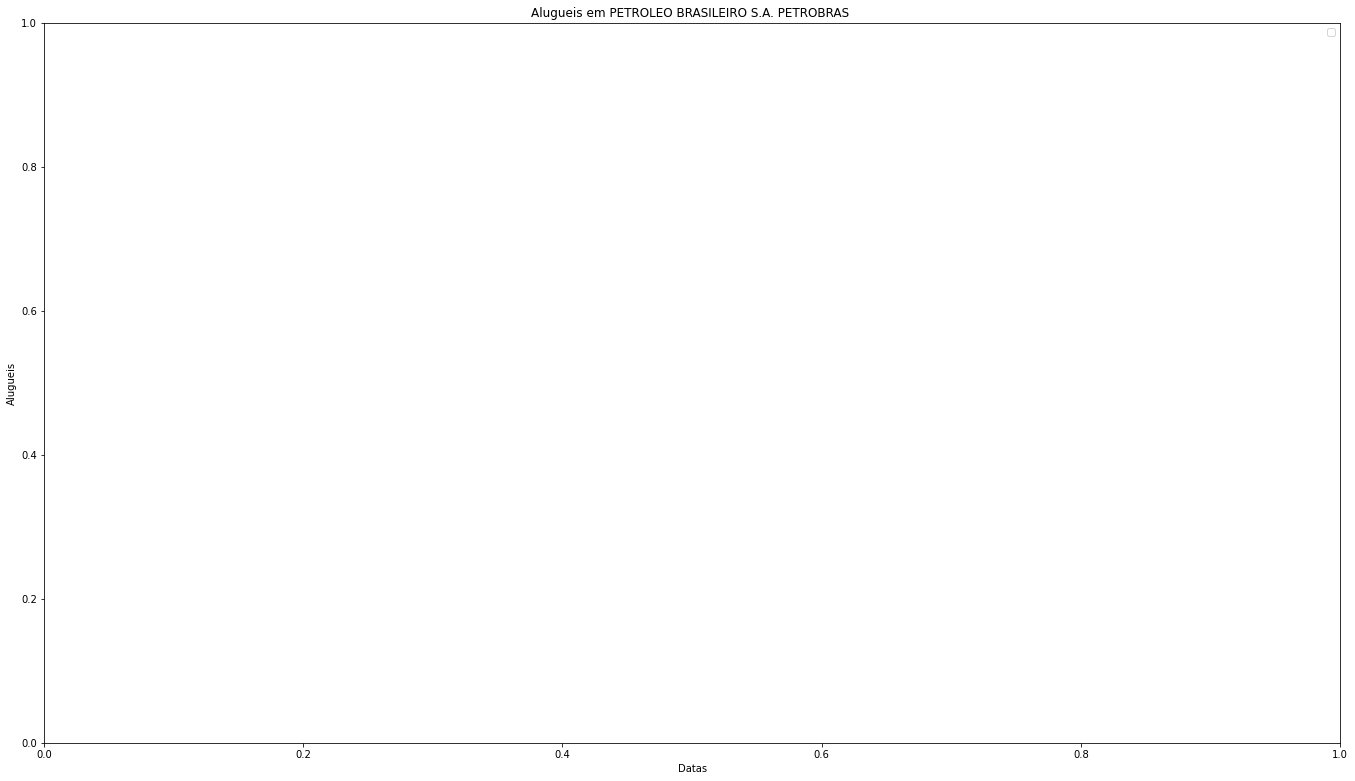

In [ ]:
tabelaAlugueis = []
linhas = ['PETR3','PETR4']
for (dfAluguel) in alugueis:
  print(dfAluguel)
  linha = [ticker]
  linha.extend(vendas)
  tabelaVendasTotais.append(linha)


fig = plt.figure(figsize=(18,10))
axes = fig.add_axes([1,1,1,1])
axes.set_xlabel('Datas')
axes.set_ylabel('Alugueis')
axes.set_title('Alugueis em ' + empresa['nome'] + " ")

for linha in alugueis:
  axes.plot(datas,linha[2],label=linha[0])
axes.legend()